In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torchvision

# this will automatically download the MNIST training set
mnist_train = torchvision.datasets.MNIST(root='./data', 
                                         train=True, 
                                         download=True, 
                                         transform=torchvision.transforms.ToTensor())
print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!

 Download complete! Downloaded 60000 training examples!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


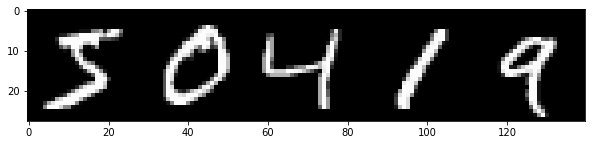

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Let's display some of the training samples.
sample_images = []
mnist_it = iter(mnist_train)  # create simple iterator, later we will use proper DataLoader
for _ in range(5):
  sample = next(mnist_it)     # samples a tuple (image, label)
  sample_images.append(sample[0][0].data.cpu().numpy())

fig = plt.figure(figsize = (10, 50))   
ax1 = plt.subplot(111)
ax1.imshow(np.concatenate(sample_images, axis=1), cmap='gray')
plt.show()


# 2. Auto-Encoder

**auto-encoder architecture**. Auto-encoders feature the same encoder-decoder architecture as VAEs and therefore also learn a low-dimensional representation of the input data without supervision. In contrast to VAEs they are **fully deterministic** models and do not employ variational inference for optimization.

The **architecture** is very simple: we will encode the input image into a low-dimensional representation using a convolutional network with strided convolutions that reduce the image resolution in every layer. This results in a low-dimensional representation of the input image. This representation will get decoded back into the dimensionality of the input image using a convolutional decoder network that mirrors the architecture of the encoder. It employs transposed convolutions to increase the resolution of its input in every layer. The whole model is trained by **minimizing a reconstruction loss** between the input and the decoded image.

Intuitively, the **auto-encoder needs to compress the information contained in the input image** into a much lower dimensional representation (e.g. 28x28=784px vs. 64 embedding dimensions for our MNIST model). This is possible since the information captured in the pixels is *highly redundant*. E.g. encoding an MNIST image requires <4 bits to encode which of the 10 possible digits is displayed and a few additional bits to capture information about shape and orientation. This is much less than the $255^{28\cdot 28}$ bits of information that could be theoretically captured in the input image.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

## Defining the Auto-Encoder Architecture

In [6]:
import torch.nn as nn

# encoder and decoder networks
#####################################################################
# Encoder Architecture:                                             #
#   - Conv2d, hidden units: 32, output resolution: 14x14, kernel: 4 #
#   - LeakyReLU                                                     #
#   - Conv2d, hidden units: 64, output resolution: 7x7, kernel: 4   #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - Conv2d, hidden units: 128, output resolution: 3x3, kernel: 3  #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - Conv2d, hidden units: 256, output resolution: 1x1, kernel: 3  #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - Flatten                                                       #
#   - Linear, output units: nz (= representation dimensionality)    #
#####################################################################

class Encoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    
    self.net = nn.Sequential(
        # network layers here
        # ...
        nn.Conv2d(1,32,4, stride=2, padding=1, bias=True),
        nn.LeakyReLU(),
        nn.Conv2d(32,64,4, stride=2, padding=1, bias=True),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(64,128,3, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(128,256,3, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Flatten(),
        nn.Linear(256,nz)

    )
    
  
  def forward(self, x):
    return self.net(x)


#####################################################################
# Decoder Architecture (mirrors encoder architecture):              #
#   - Linear, output units: 256                                     #
#   - Reshape, output shape: (256, 1, 1)                            #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - ConvT2d, hidden units: 128, output resolution: 3x3, kernel: 3 #
#   - BatchNorm2d                                                   #
#   - LeakyReLU                                                     #
#   - ConvT2d, hidden units: 64, output resolution: 7x7, kernel: 3  #
#   - ...                                                           #
#   - ...                                                           #
#   - ConvT2d, output units: 1, output resolution: 28x28, kernel: 4 #
#   - Sigmoid (to limit output in range [0...1])                    #
#####################################################################

class Decoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    #################################      #########################################
    # We need to separate the intial linear layer into a separate variable since   #
    # nn.Sequential does not support reshaping. Instead the "Reshape" is performed #
    # in the forward() function below and does not need to be added to self.net    #
    ################################################################################
    self.map = nn.Linear(nz,256)   # for initial Linear layer
    self.net = nn.Sequential(
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(256,128,3, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(128,64,3, stride=2, padding=0, bias=True),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64,32,4, stride=2, padding=1, bias=True),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32,1,4, stride=2, padding=1, bias=True),
        nn.Sigmoid()

    )

  
  def forward(self, x):
    return self.net(self.map(x).reshape(-1, 256, 1, 1))

## Testing the Auto-Encoder Forward Pass

In [7]:
# To test your encoder/decoder, let's encode/decode some sample images
# first, make a PyTorch DataLoader object to sample data batches
batch_size = 64
nworkers = 4        # number of wrokers used for efficient data loading

from torch.utils.data import DataLoader
mnist_data_loader = DataLoader(mnist_train, batch_size = batch_size, num_workers = nworkers, shuffle = True)


# now we can run a forward pass for encoder and decoder and check the produced shapes
nz = 64          # dimensionality of the learned embedding
encoder = Encoder(nz)
decoder = Decoder(nz)
for sample_img, sample_label in mnist_data_loader:
  enc = encoder(sample_img)
  print("Shape of encoding vector (should be [batch_size, nz]): {}".format(enc.shape))
  dec = decoder(enc)
  print("Shape of decoded image (should be [batch_size, 1, 28, 28]): {}".format(dec.shape))    
  break

Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 64])
Shape of decoded image (should be [batch_size, 1, 28, 28]): torch.Size([64, 1, 28, 28])


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [8]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz)
    self.decoder = Decoder(nz)

  def forward(self, x):
    temp_val = self.encoder(x)
    return self.decoder(self.encoder(x))

  def reconstruct(self, x):
    """Only used later for visualization."""
    return self.forward(x)

## Setting up the Auto-Encoder Training Loop

In [9]:
epochs = 10
learning_rate = 1e-3

# build AE model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
ae_model = AutoEncoder(nz).to(device)    # transfer model to GPU if available
ae_model = ae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function

opt = torch.optim.Adam(ae_model.parameters(), lr=learning_rate, weight_decay=1e-5) # create optimizer instance
criterion = nn.MSELoss()    # create loss layer instance


train_it = 0
for ep in range(epochs):
  print("Run Epoch {}".format(ep))

  for data in mnist_data_loader:
    img, lbl = data
    img = img.to(device)
    lbl = lbl.to(device)
    #img = torch.autograd.Variable(img)

    opt.zero_grad()
    
    out = ae_model(img)
    rec_loss = criterion(out,img)
    
    rec_loss.backward()
    opt.step()
    #print('epoch [{}/{}], loss:{:.4f}'.format(ep+1, epochs, rec_loss.data))

    if train_it % 100 == 0:
      print("It {}: Reconstruction Loss: {}".format(train_it, rec_loss))
    train_it += 1
  
print("Done!")

Run Epoch 0
It 0: Reconstruction Loss: 0.23774968087673187
It 100: Reconstruction Loss: 0.026495179161429405
It 200: Reconstruction Loss: 0.015377625823020935
It 300: Reconstruction Loss: 0.01389250811189413
It 400: Reconstruction Loss: 0.01395979430526495
It 500: Reconstruction Loss: 0.01047509629279375
It 600: Reconstruction Loss: 0.010843274183571339
It 700: Reconstruction Loss: 0.009892155416309834
It 800: Reconstruction Loss: 0.009634925983846188
It 900: Reconstruction Loss: 0.008307917974889278
Run Epoch 1
It 1000: Reconstruction Loss: 0.009538346901535988
It 1100: Reconstruction Loss: 0.00826256349682808
It 1200: Reconstruction Loss: 0.009605620056390762
It 1300: Reconstruction Loss: 0.00825886894017458
It 1400: Reconstruction Loss: 0.00842822715640068
It 1500: Reconstruction Loss: 0.007899114862084389
It 1600: Reconstruction Loss: 0.0081907594576478
It 1700: Reconstruction Loss: 0.0085535803809762
It 1800: Reconstruction Loss: 0.007676520850509405
Run Epoch 2
It 1900: Reconstru

## Verifying reconstructions
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit.

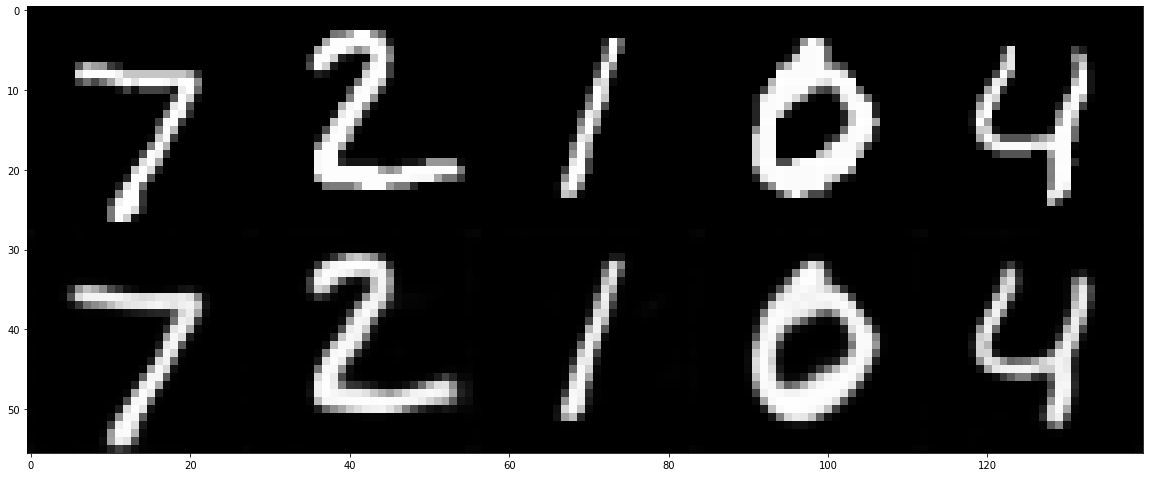

In [10]:
# visualize test data reconstructions
def vis_reconstruction(model):
  # download MNIST test set + build Dataset object
  mnist_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          download=True, 
                                          transform=torchvision.transforms.ToTensor())
  mnist_test_iter = iter(mnist_test)
  model.eval()      # set model in evalidation mode (eg freeze batchnorm params)
  input_imgs, test_reconstructions = [], []
  for _ in range(5):
    input_img = np.asarray(next(mnist_test_iter)[0])
    reconstruction = model.reconstruct(torch.tensor(input_img[None], device=device))
    input_imgs.append(input_img[0])
    test_reconstructions.append(reconstruction[0, 0].data.cpu().numpy())

  fig = plt.figure(figsize = (20, 50))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate([np.concatenate(input_imgs, axis=1),
                            np.concatenate(test_reconstructions, axis=1)], axis=0), cmap='gray')
  plt.show()

vis_reconstruction(ae_model)

## Sampling from the Auto-Encoder

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

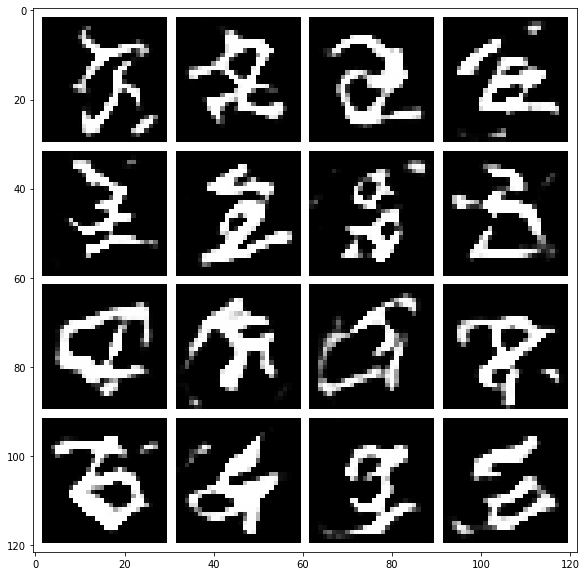

In [11]:
# we will sample N embeddings, then decode and visualize them
def vis_samples(model):
  
  #sampled_embeddings = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(nz), torch.eye(nz)).sample(sample_shape=torch.Size([batch_size])).to(device) # sample batch of embedding from prior
  sampled_embeddings = torch.normal(0,1,(batch_size,nz)).to(device)
  
  #using numpy
  '''
  arr = np.random.normal(0, 1, [100, batch_size, nz])
  samples = torch.from_numpy(arr).float()
  '''

  decoded_samples = model.decoder(sampled_embeddings)       # decoder output images for sampled embeddings

  fig = plt.figure(figsize = (10, 10))
  ax1 = plt.subplot(111)
  ax1.imshow(torchvision.utils.make_grid(decoded_samples[:16], nrow=4, pad_value=1.)\
                .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
  plt.show()

vis_samples(ae_model)


# 3. Variational Auto-Encoder (VAE)

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$

Here, $D_{\text{KL}}(q, p)$ denotes the Kullback-Leibler (KL) divergence between the posterior distribution $q(z \vert x)$, i.e. the output of our encoder, and $p(z)$, the prior over the embedding variable $z$, which we can choose freely.

For simplicity, we will again choose a unit Gaussian prior. The left term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} (x - \hat{x})^2 - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$

Here, $\hat{x}$ is the reconstruction output of the decoder. In comparison to the auto-encoder objetive, the VAE adds a regularizing term between the output of the encoder and a chosen prior distribution, effectively forcing the encoder output to not stray too far from the prior during training. As a result the decoder gets trained with samples that look pretty similar to samples from the prior, which will hopefully allow us to generate better images when using the VAE as a generative model and actually feeding it samples from the prior (as we have done for the AE before).

The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.

If you need a refresher on VAEs you can check out this tutorial paper: https://arxiv.org/abs/1606.05908

### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model

In [12]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """Computes KL[p||q] between two Gaussians defined by [mu, log_sigma]."""
  return (log_sigma2 - log_sigma1) + (torch.exp(log_sigma1) ** 2 + (mu1 - mu2) ** 2) \
               / (2 * torch.exp(log_sigma2) ** 2) - 0.5


class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta          # factor trading off between two loss components
    
    # Instantiate Encoder and Decoder.                                                 #
    # encoder is now parametrizing a Gaussian distribution's   #
    # mean and log_sigma, so the dimensionality of the output embedding needs to #
    # double.                                                                    #
    
    self.encoder = Encoder(nz*2) # check here
    
    self.decoder = Decoder(nz)
    

  def forward(self, x):
    # encode input into posterior distribution q(z | x)

    q = self.encoder(x)       # output of encoder (concatenated mean and log_sigma)
    q = q.to(device)
    
    mean_val = q[..., :nz]
    log_sigma = q[..., nz:]

    #mean_val, log_sigma = torch.chunk(q, 2, dim = 1)
    
   
    mean_val = mean_val.to(device)
    log_sigma = log_sigma.to(device)

    # sample latent variable z with reparametrization
    #sampled_embeddings = torch.normal(0,1,(x.shape[0],nz)).to(device)
    #sampled_embeddings = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(nz), torch.eye(nz)).sample(sample_shape=torch.Size([x.shape[0]])).to(device)

    eps = torch.normal(0,1,(mean_val.shape)).to(device)

    #eps = torch.randn(size = mean_val.shape).to(device)
    z = mean_val + (torch.exp(log_sigma)*eps)
    
    #z = eps*log_sigma + mean_val       # batch of sampled embeddings
    z = z.to(device)

    # compute reconstruction
    reconstruction = self.decoder(z)   # decoder reconstruction from embedding

    return {'q': q,
            'rec': reconstruction}

  def loss(self, x, outputs):
  
    # compute reconstruction loss
    rec_loss = nn.MSELoss()(outputs['rec'],x)

    # compute KL divergence loss

    #mu1, log_sigma1 = torch.chunk(outputs['q'], 2, dim = 1)
    mu1 = outputs['q'][..., :nz]
    log_sigma1 = outputs['q'][..., nz:]
    #mu1, h = torch.split(outputs['q'], outputs['q'].size(1) // 2, dim=1)
    #var1 = torch.nn.functional.softplus(h) + 1e-8

    #mu1 = outputs['q'][..., :nz]
    #log_sigma1 = outputs['q'][..., nz: ]
    
    mu1 = mu1.to(device)
    log_sigma1 = (log_sigma1.to(device))

    #mu2, log_sigma2 = torch.zeros(x.shape[0],nz), torch.zeros(x.shape[0],nz)
    mu2, log_sigma2 = torch.zeros_like(log_sigma1), torch.zeros_like(log_sigma1)
    mu2 = mu2.to(device)
    log_sigma2 = log_sigma2.to(device)

    kl_loss = kl_divergence(mu1, log_sigma1, mu2, log_sigma2).mean()   # make sure that this is a scalar, not a vector / array
    #kl_loss = kl_loss.item()
 

    # return weihgted objective
    return rec_loss + self.beta * kl_loss, \
           {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    #mean_val, log_sigma = torch.chunk(self.encoder(x), 2, dim = 1)
    
    q = self.encoder(x)
    mean_val = q[..., :nz]
    log_sigma1 = q[..., nz:]
    #mean_val, h = torch.split(q, q.size(1) // 2, dim=1)

    reconstruction = self.decoder(mean_val)
    #################################### END TODO ######################################
    return reconstruction


## Setting up the VAE Training Loop

Run Epoch 0
It 0: Total Loss: 0.21450111269950867, 	 Rec Loss: 0.18621253967285156,	 KL Loss: 0.28288573026657104
It 100: Total Loss: 0.06466814875602722, 	 Rec Loss: 0.06319047510623932,	 KL Loss: 0.014776760712265968
It 200: Total Loss: 0.06094888970255852, 	 Rec Loss: 0.055689312517642975,	 KL Loss: 0.05259576067328453
It 300: Total Loss: 0.0609792061150074, 	 Rec Loss: 0.053592536598443985,	 KL Loss: 0.07386671006679535
It 400: Total Loss: 0.052292756736278534, 	 Rec Loss: 0.042887646704912186,	 KL Loss: 0.09405109286308289
It 500: Total Loss: 0.05052163824439049, 	 Rec Loss: 0.04053056985139847,	 KL Loss: 0.0999106913805008
It 600: Total Loss: 0.050995562225580215, 	 Rec Loss: 0.03965391218662262,	 KL Loss: 0.11341649293899536
It 700: Total Loss: 0.0502348318696022, 	 Rec Loss: 0.03924119099974632,	 KL Loss: 0.10993642359972
It 800: Total Loss: 0.04741266369819641, 	 Rec Loss: 0.03589353337883949,	 KL Loss: 0.11519131064414978
It 900: Total Loss: 0.05031156539916992, 	 Rec Loss: 0

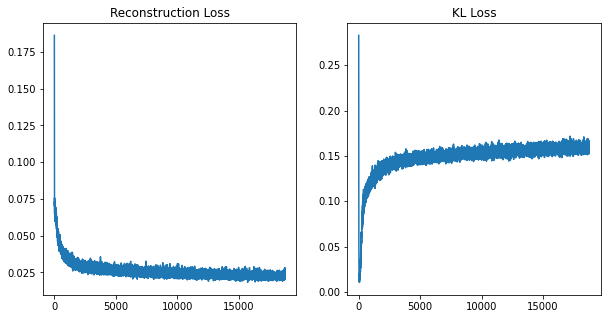

In [17]:
learning_rate = 1e-3
nz = 64

####################################### TODO #######################################
# Tune the beta parameter to obtain good VAE training results. However, for the    #
# initial experiments leave beta = 0 in order to verify our implementation.        #
####################################################################################
epochs = 20         # using 5 epochs is sufficient for the first two experiments
                   # for the experiment where you tune beta, 20 epochs are appropriate
beta = 0.1
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
opt = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  for data in mnist_data_loader:
    img, lbl = data
    img = img.to(device)
    lbl = lbl.to(device)
    opt.zero_grad()
    #img = torch.autograd.Variable(img)
    img_vae = vae_model(img)
    total_loss,losses = vae_model.loss(img,img_vae)
    #total_loss = loss_tuple[0]
    #losses = loss_tuple[1]
    
    total_loss.backward()
    opt.step()

    rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
  
print("Done!")

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss)
ax2.title.set_text("KL Loss")
plt.show()

Let's look at some reconstructions and decoded embedding samples!

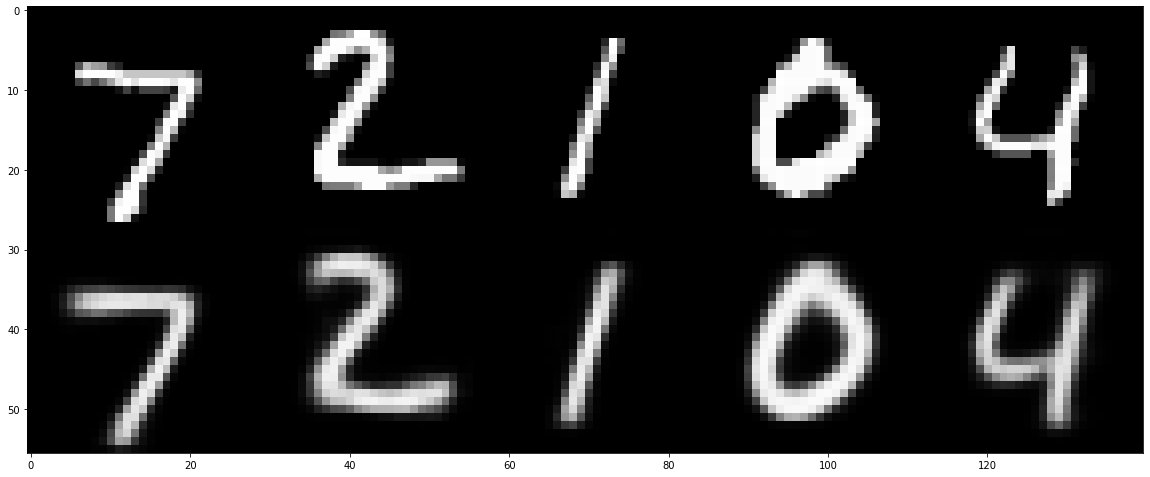

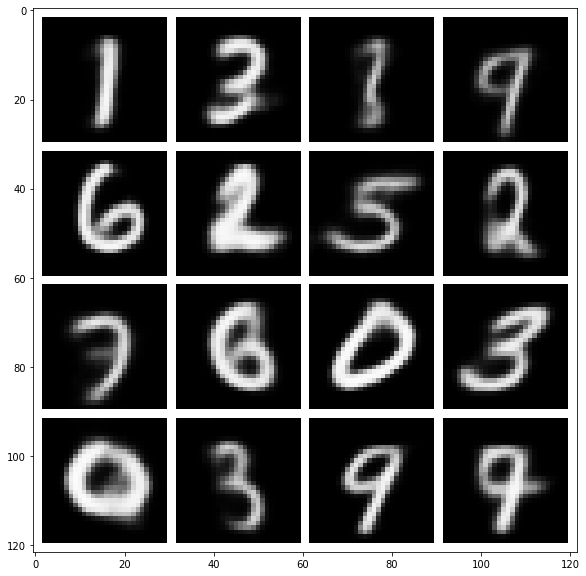

In [19]:
# visualize VAE reconstructions and samples from the generative model
vis_reconstruction(vae_model)
vis_samples(vae_model)